In [1]:
import numpy as np
import pyccl as ccl
import cluster_toolkit as ct

In [2]:
# Define CCL cosmology object
cosmo_ccl = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)

# Select density profile and profile parametrization options 
density_profile_parametrization = 'nfw'
mass_Delta = 200
cluster_mass = 1.e15
cluster_concentration = 4


#  Note:  
## We have decided to use
### - get_ to signal easy to pull values based on cosmology.
### - compute_ to signal things in the background (integration, etc. to get normalization right).
### - calculate_ to signal quick derived values based on things that were computed.



In [3]:
def get_3d_density_profile(r3d, mdelta, cdelta, cosmo, Delta=200, halo_profile_parameterization='nfw'):
    Om_m = cosmo['Omega_c']+cosmo['Omega_b']

    if halo_profile_parameterization=='nfw':
        return ct.density.rho_nfw_at_r(r3d, mdelta, cdelta, Om_m, delta=Delta)
    else:
        pass              


In [4]:
def calculate_surface_density(r_proj, mdelta, cdelta, cosmo, Delta=200, halo_profile_parameterization='nfw'
                                        ):
    """Sigma"""

    Om_m = cosmo['Omega_c']+cosmo['Omega_b']
    
    if halo_profile_parameterization=='nfw':
        return ct.deltasigma.Sigma_nfw_at_R(r_proj, mdelta, cdelta, Om_m, delta=Delta)
    else:
        #return ct.Sigma_at_R(r_proj, mdelta, cdelta, cosmo.Omegam, delta=Delta)
        pass



In [5]:
def calculate_excess_surface_density(r_proj, mdelta, cdelta, cosmo, Delta=200, 
                                     halo_profile_parameterization='nfw'):
    """DeltaSigma"""

    Om_m = cosmo['Omega_c']+cosmo['Omega_b']
    
    if halo_profile_parameterization == 'nfw' :
    
        Sigma = ct.deltasigma.Sigma_nfw_at_R(r_proj, mdelta, cdelta, Om_m, delta=Delta)
        # ^ Note: Let's not use this naming convention when transfering ct to ccl.... 
        return ct.deltasigma.DeltaSigma_at_R(r_proj, r_proj, Sigma, mdelta, cdelta, Om_m, delta=Delta)
    else :
        pass


In [6]:
def _comoving_angular_distance_aexp1_aexp2(cosmo, aexp1, aexp2):
    z1 = 1./aexp1 - 1.
    z2 = 1./aexp2 - 1. 
    from astropy.cosmology import FlatLambdaCDM
    from astropy import units as u
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    return cosmo.angular_diameter_distance_z1z2(z1, z2).to_value(u.pc)*cosmo.h
    

def get_critical_surface_density(cosmo, z_cluster, z_source):
    
    m_to_pc = 3.2408e-17 
    kg_to_Msun = 5.0279e-31
    c = ccl.physical_constants.CLIGHT*m_to_pc
    G = ccl.physical_constants.GNEWT*m_to_pc**3/kg_to_Msun
    aexp_cluster = 1./(1.+z_cluster)
    aexp_src = 1./(1.+z_source)
    
    mpc2pc = 1.e6
    d_l = ccl.comoving_angular_distance(cosmo, aexp_cluster)*aexp_cluster*mpc2pc*cosmo['h']
    d_s = ccl.comoving_angular_distance(cosmo, aexp_src)*aexp_src*mpc2pc*cosmo['h']
    d_ls = _comoving_angular_distance_aexp1_aexp2(cosmo, aexp_cluster, aexp_src)

    # will need to deal with units: distances in Mpc and some CCL constants in SI
    return d_s/(d_l*d_ls) * c*c/(4*np.pi*G)
    

In [7]:
def compute_tangential_shear_profile(r_proj, mdelta, cdelta, z_cluster, z_source, cosmo, Delta=200, 
                                     halo_profile_parameterization='nfw', 
                                     z_src_model='single_plane'):
    '''gamma_t
    
    Note:  We will need gamma inf and kappa inf
    '''
    delta_sigma = calculate_excess_surface_density(r_proj, mdelta, cdelta, cosmo, Delta=Delta, 
                                                   halo_profile_parameterization=halo_profile_parameterization)
        
    if z_src_model == 'single_plane':
        sigma_c = get_critical_surface_density(cosmo, z_cluster, z_source)
        return delta_sigma / sigma_c
    elif z_src_model == 'known_z_src': # Discrete case
        NotImplementedError('Need to implemnt Beta_s functionality, or average delta_sigma/sigma_c gamma_t = Beta_s*gamma_inf')
    elif z_src_model == 'z_src_distribution' : # Continuous ( from a distribution) case
        NotImplementedError('Need to implement Beta_s calculation from integrating distribution of redshifts in each radial bin')

In [8]:
def compute_convergence_profile(r_proj, mdelta, cdelta, z_cluster, z_source, cosmo, Delta=200, 
                                     halo_profile_parameterization='nfw', 
                                    z_src_model='single_plane'):
    '''kappa'''

    sigma = calculate_surface_density(r_proj, mdelta, cdelta, cosmo, Delta=Delta, 
                                                      halo_profile_parameterization=halo_profile_parameterization)
    
    if z_src_model == 'single_plane':
        sigma_c = get_critical_surface_density(cosmo, z_cluster, z_source)
        return sigma / sigma_c
    elif z_src_model == 'known_z_src': # Discrete case
        NotImplementedError('Need to implemnt Beta_s functionality, or average sigma/sigma_c kappa_t = Beta_s*kappa_inf')
    elif z_src_model == 'z_src_distribution' : # Continuous ( from a distribution) case
        NotImplementedError('Need to implement Beta_s calculation from integrating distribution of redshifts in each radial bin')

In [9]:
def compute_reduced_tangential_shear_profile(r_proj, mdelta, cdelta, z_cluster, z_source, cosmo, Delta=200, 
                                             halo_profile_parameterization='nfw', 
                                                z_src_model='single_plane'):
    '''
    Computes the reduced tangential shear profile:  
    $g_t = \frac{\\gamma_t}{1-\\kappa}$.
    
    Parameters
    ----------
    r_proj : array-like
        The projected radial positions in Mpc/h.
    mdelta : float
        Galaxy cluster mass in Msun/h.
    cdelta : float
        Galaxy cluster NFW concentration.
    z_cluster : float
        Galaxy cluster redshift
    z_source : float
        Background source galaxy redshift
    cosmo : object
        ccl cosmology object
    Delta : :obj:`int`, optional
        Mass overdensity definition.  Defaults to 200.
    halo_profile_parameterization :obj:`str`, optional
        Profile model parameterization that we wish to use, with the following supported options:
        `nfw` (default) - [insert citation here]
    z_src_model :obj:`str`, optional
        Source redshift model, with the following supported options:
        `single_plane` (default) - all sources at one redshift
        `known_z_src` - known individual source galaxy redshifts, e.g. discrete case
        `z_src_distribution` - known source redshift distribution, e.g. continuous case requiring integration.


    Returns
    -------
    array-like
        Reduced tangential shear.
        
        
    '''
    
    if z_src_model == 'single_plane':
        kappa = compute_convergence_profile(r_proj, mdelta, cdelta, z_cluster, z_source, cosmo, Delta, 
                                         halo_profile_parameterization,
                                        z_src_model)
        gamma_t = compute_tangential_shear_profile(r_proj, mdelta, cdelta, z_cluster, z_source, cosmo, Delta, 
                                         halo_profile_parameterization,
                                        z_src_model)
        return gamma_t / (1 - kappa)
    elif z_src_model == 'known_z_src': # Discrete case
        NotImplementedError('Need to implemnt Beta_s functionality, or average sigma/sigma_c kappa_t = Beta_s*kappa_inf')
    elif z_src_model == 'z_src_distribution' : # Continuous ( from a distribution) case
        NotImplementedError('Need to implement Beta_s and Beta_s2 calculation from integrating distribution of redshifts in each radial bin')
    

In [10]:
# Quick test of functions

r3d = np.logspace(-2,2,100)

rho = get_3d_density_profile(r3d,mdelta=cluster_mass, cdelta=cluster_concentration, cosmo=cosmo_ccl)

Sigma = calculate_surface_density(r3d, cluster_mass, cluster_concentration, cosmo=cosmo_ccl, Delta=200, 
                                  halo_profile_parameterization='nfw')

DeltaSigma = calculate_excess_surface_density(r3d, cluster_mass, cluster_concentration, cosmo=cosmo_ccl, Delta=200, 
                                              halo_profile_parameterization='nfw')

Sigmac = get_critical_surface_density(cosmo_ccl, z_cluster=1.0, z_source=2.0)

gammat = compute_tangential_shear_profile(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, z_cluster=1.0, 
                                          z_source=2.0, cosmo=cosmo_ccl, Delta=200, 
                                          halo_profile_parameterization='nfw', z_src_model='single_plane')

kappa = compute_convergence_profile(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, 
                            z_cluster=1.0, z_source=2.0,
                                 cosmo=cosmo_ccl, Delta=200, 
                                     halo_profile_parameterization='nfw', 
                                    z_src_model='single_plane')

gt = compute_reduced_tangential_shear_profile(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, 
                                         z_cluster=1.0, z_source=2.0, cosmo=cosmo_ccl, Delta=200, 
                                         halo_profile_parameterization='nfw', z_src_model='single_plane')
        

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_profile(r, profile_vals, profile_label='rho'):
    plt.loglog(r, profile_vals)
    plt.xlabel('r [Mpc]', fontsize='xx-large')
    plt.ylabel(profile_label, fontsize='xx-large')

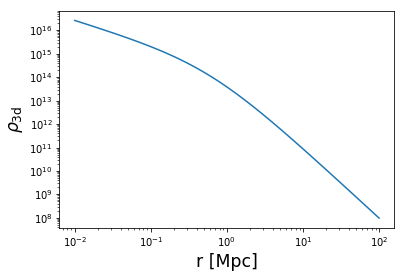

In [12]:
plot_profile(r3d, rho, '$\\rho_{\\rm 3d}$')

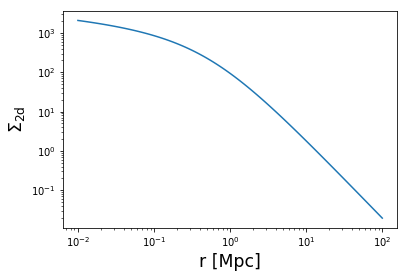

In [13]:
plot_profile(r3d, Sigma, '$\\Sigma_{\\rm 2d}$')

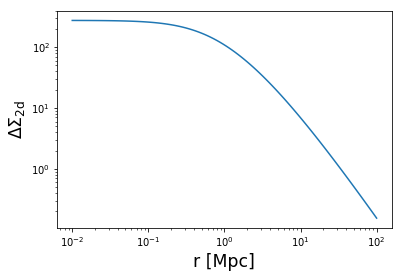

In [14]:
plot_profile(r3d, DeltaSigma, '$\\Delta\\Sigma_{\\rm 2d}$')

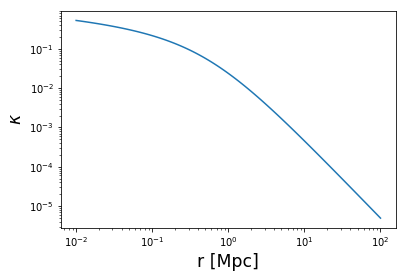

In [15]:
plot_profile(r3d, kappa, '$\\kappa$')
# Note - here is clear units problem

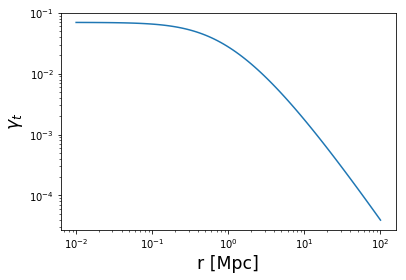

In [16]:
plot_profile(r3d, gammat, '$\\gamma_t$')

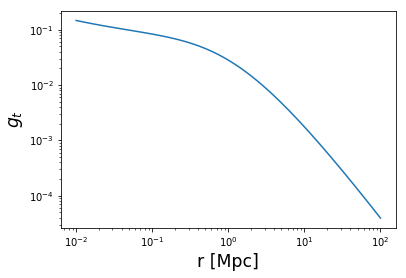

In [17]:
plot_profile(r3d, gt, '$g_t$')